In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

import joblib

In [3]:
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Energy Forecasting/data")
data = pd.read_csv(data_dir / "final_data.csv")
data["datetime"] = pd.to_datetime(data["datetime"])
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   datetime                        27555 non-null  datetime64[ns]
 1   Demand (MW)                     27555 non-null  float64       
 2   Name                            27555 non-null  object        
 3   Temperature                     27555 non-null  float64       
 4   feelslike                       27555 non-null  float64       
 5   dewpoint                        27555 non-null  float64       
 6   humidity                        27555 non-null  float64       
 7   precipitation                   27555 non-null  float64       
 8   precipprob                      27555 non-null  float64       
 9   snow                            27555 non-null  float64       
 10  snowdepth                       27555 non-null  float64       
 11  wi

,datetime,Demand (MW),Name,Temperature,feelslike,dewpoint,humidity,precipitation,precipprob,snow,...,solarradiation,uvindex,severerisk,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow
0,2020-01-01 00:00:00,445.8,Pokhara,38.0,34.4,29.0,69.76,0.0,0.0,0.0,...,0.0,0.0,13.10842,0,0,0,1,0,0,0
1,2020-01-01 01:00:00,424.5,Pokhara,38.0,34.4,29.9,72.37,0.0,0.0,0.0,...,0.0,0.0,13.10842,0,0,0,1,0,0,0
2,2020-01-01 02:00:00,423.5,Pokhara,38.0,35.7,30.8,75.06,0.0,0.0,0.0,...,0.0,0.0,13.10842,0,0,0,1,0,0,0
3,2020-01-01 03:00:00,418.8,Pokhara,37.1,33.4,29.9,74.97,0.0,0.0,0.0,...,0.0,0.0,13.10842,0,0,0,0,1,0,0
4,2020-01-01 04:00:00,414.8,Pokhara,35.1,32.3,29.0,78.41,0.0,0.0,0.0,...,0.0,0.0,13.10842,1,0,0,0,0,0,0


In [4]:
data.isnull().sum()

datetime                          0
Demand (MW)                       0
Name                              0
Temperature                       0
feelslike                         0
dewpoint                          0
humidity                          0
precipitation                     0
precipprob                        0
snow                              0
snowdepth                         0
windspeed                         0
winddirection                     0
sealevelpressure                  0
cloudcover                        0
visibility                        0
solarradiation                    0
uvindex                           0
severerisk                        0
Clear                             0
Freezing Drizzle/Freezing Rain    0
Ice                               0
Overcast                          0
Partially cloudy                  0
Rain                              0
Snow                              0
dtype: int64

### Relationship of features with demand

Text(0.5, 1.0, 'Distribution Plot of Demand (MW)')

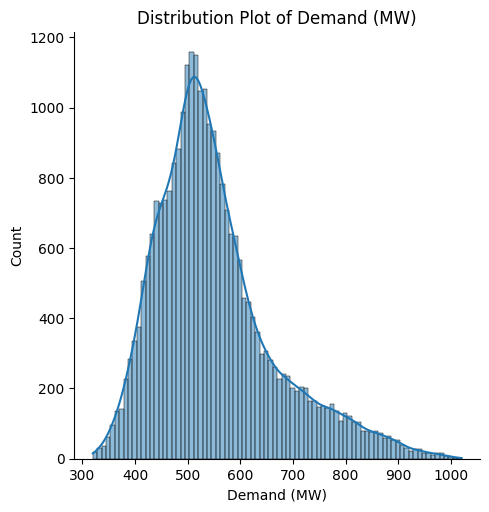

In [6]:
sns.displot(data["Demand (MW)"], kde = True)
plt.title("Distribution Plot of Demand (MW)")

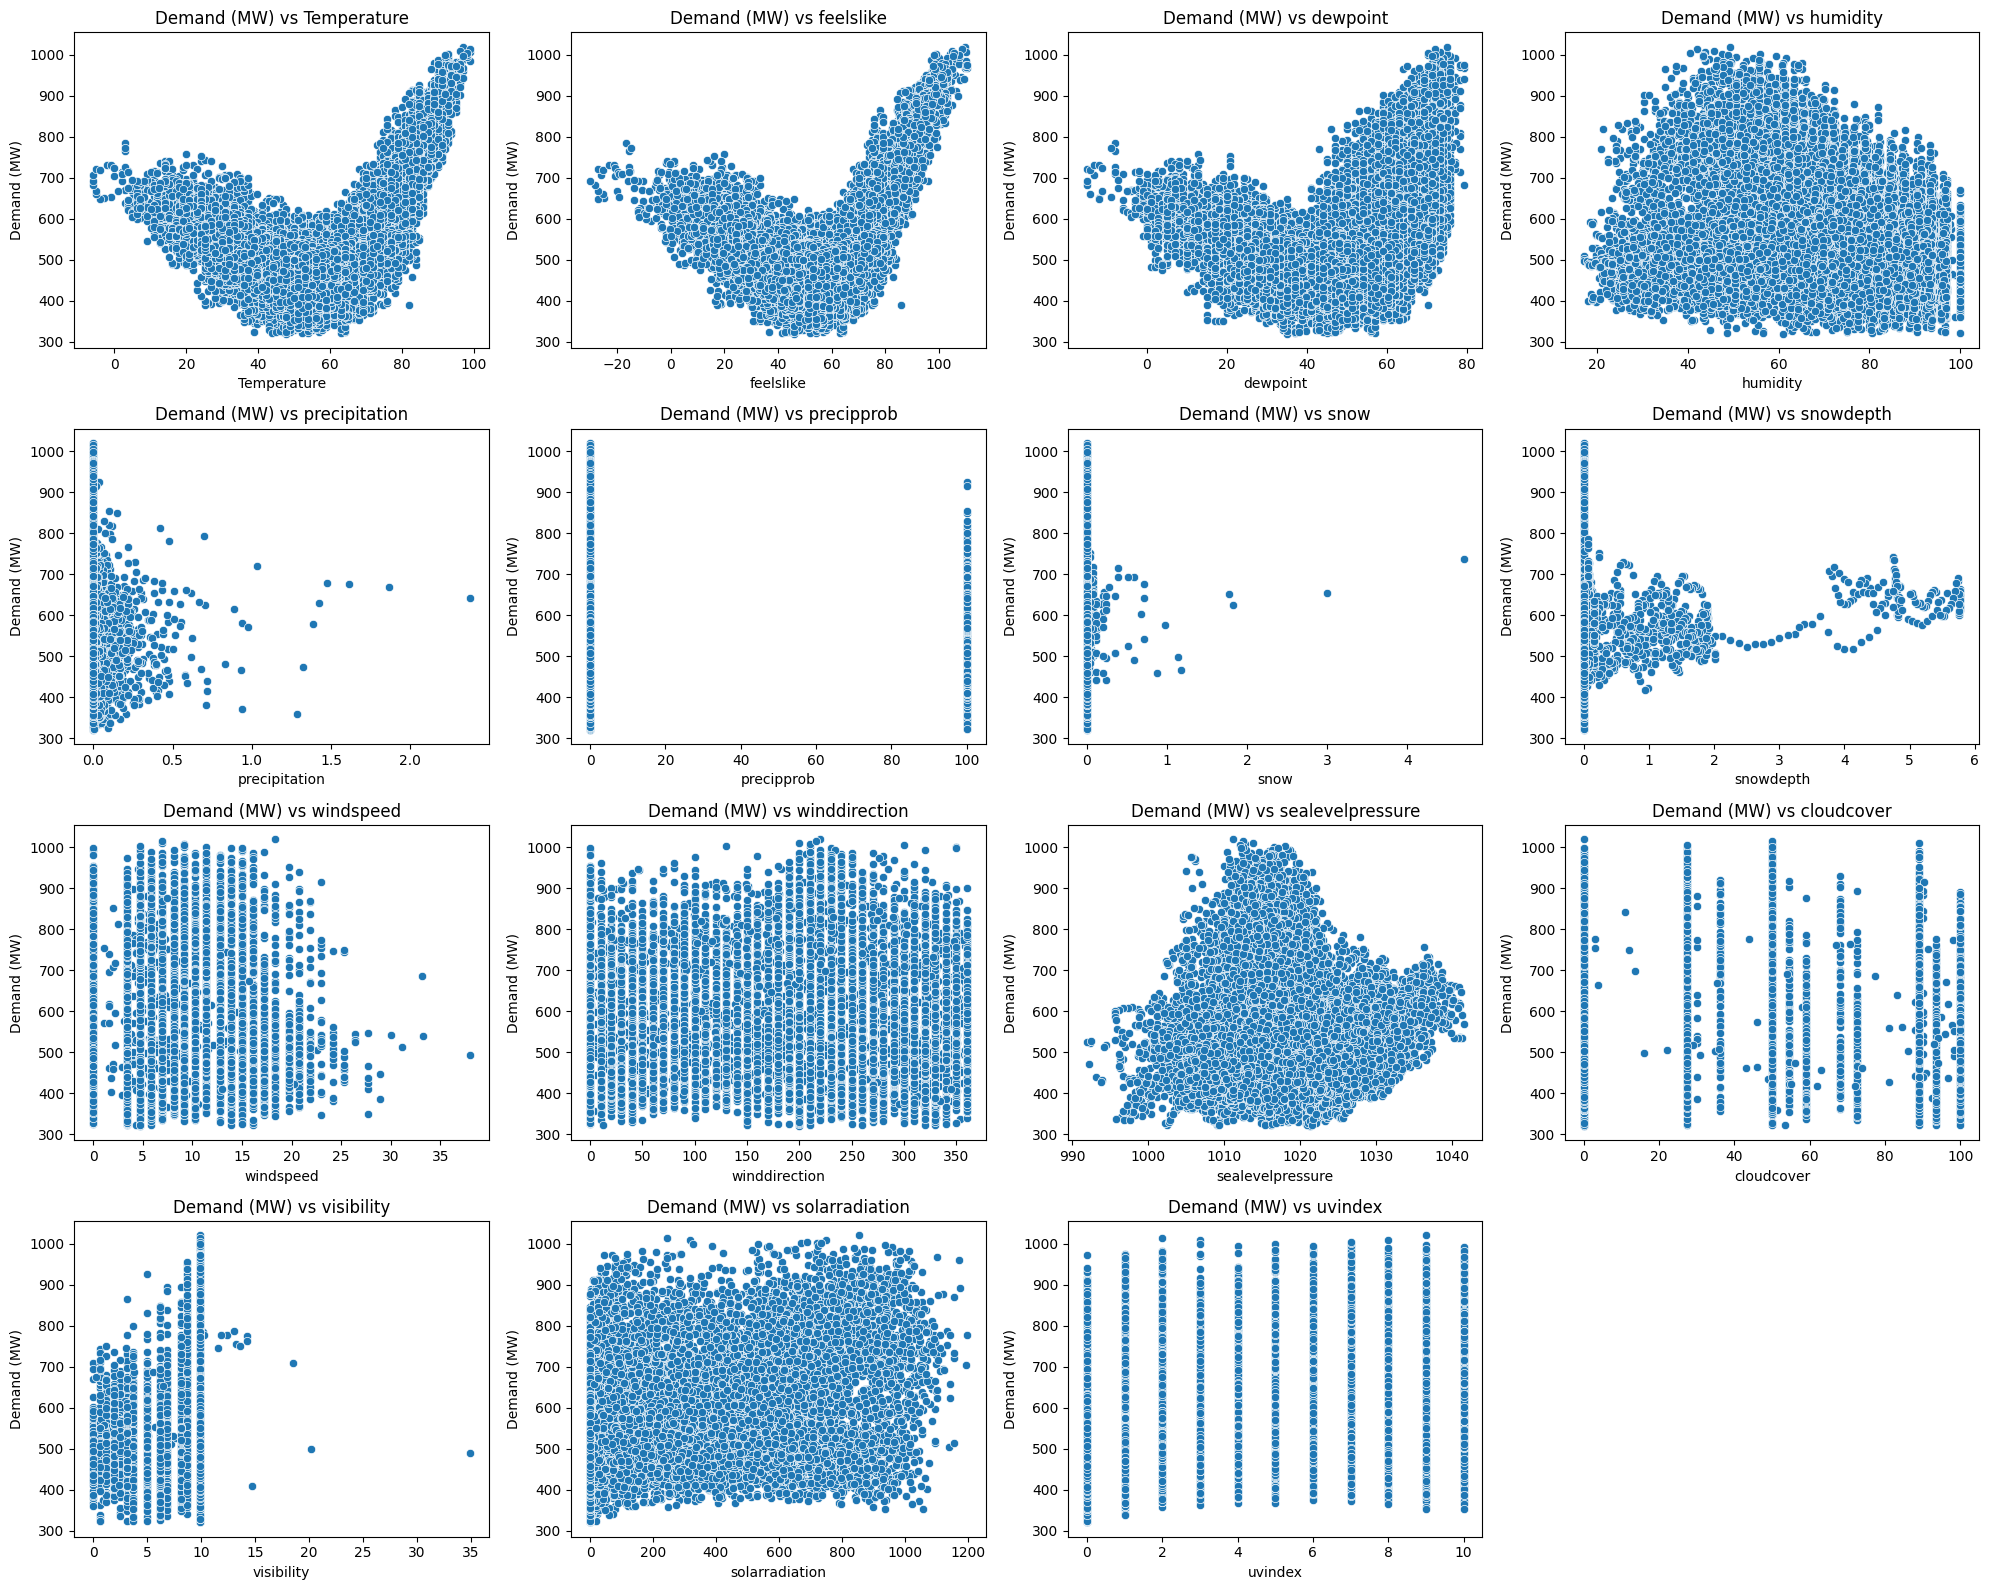

In [9]:
continuous_features = ["Temperature", "feelslike", "dewpoint", "humidity", "precipitation", "precipprob", "snow", "snowdepth", "windspeed", "winddirection", "sealevelpressure", "cloudcover", "visibility", "solarradiation", "uvindex"]
n_cols = 4
n_rows = (len(continuous_features) + n_cols) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize = (20, n_rows * 4))
axs = axs.flatten()

for i, feature in enumerate(continuous_features):
  sns.scatterplot(data = data, x = feature, y = "Demand (MW)", ax = axs[i])
  axs[i].set_title(f"Demand (MW) vs {feature}")

for j in range(i + 1, len(axs)):
  axs[j].set_visible(False)

plt.tight_layout()
plt.show()

In [12]:
discrete_feature = ["uvindex"]
for feature in discrete_feature:
  print(data[feature].value_counts())
  print()

uvindex
0.0     16595
1.0      2808
2.0      1617
3.0      1218
4.0       962
6.0       950
5.0       913
7.0       752
8.0       711
9.0       561
10.0      468
Name: count, dtype: int64



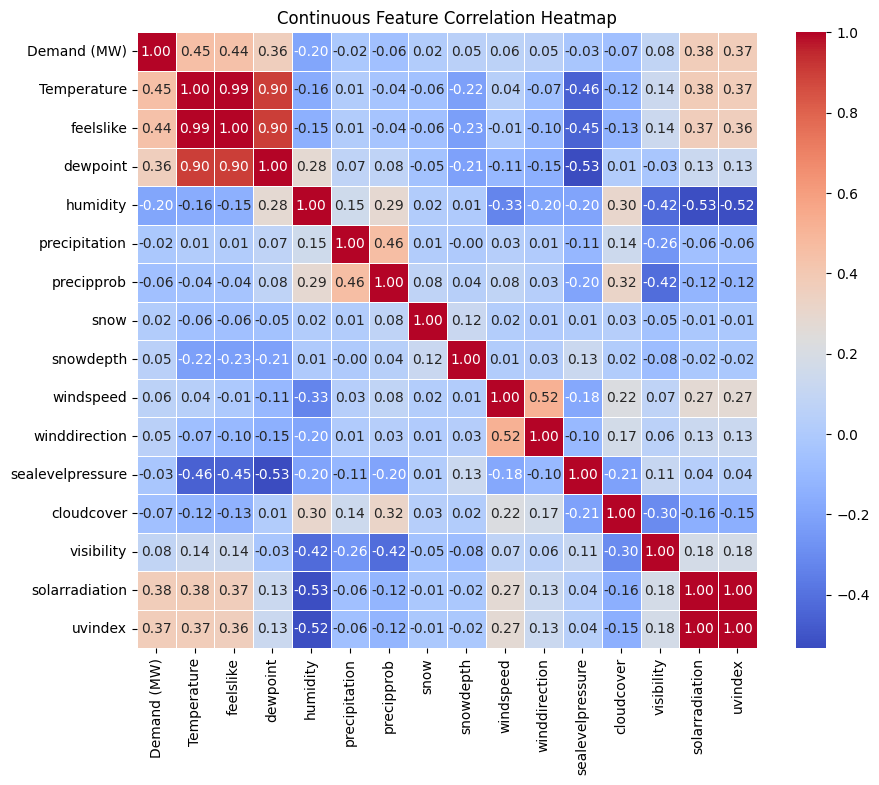

In [19]:
all_continuous_data = ["Demand (MW)", "Temperature", "feelslike", "dewpoint", "humidity", "precipitation", "precipprob", "snow", "snowdepth", "windspeed", "winddirection", "sealevelpressure", "cloudcover", "visibility", "solarradiation", "uvindex"]

correlation_matrix = data[all_continuous_data].corr()
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidth = 0.5)
plt.title('Continuous Feature Correlation Heatmap')
plt.show()

From the scatter plot and linear correlation heatmap plot, features can be divided into following categories:

**Medium Correlation with Demand (MW)** : Temperature, feelslike, dewpoint, solarradiation, uvindex

**No or near zero linear correlation with Demand (MW)** : humidity, precipitation, precipprob, snow, snowdepth, windspeed, winddirection, sealevelpressure, cloudcover, visibility

**Again few features are highly correlated with each other and hence no need to use both of them while feeding to the model. Such as**
- temperature and feelslike
- solarradiation and uvindex


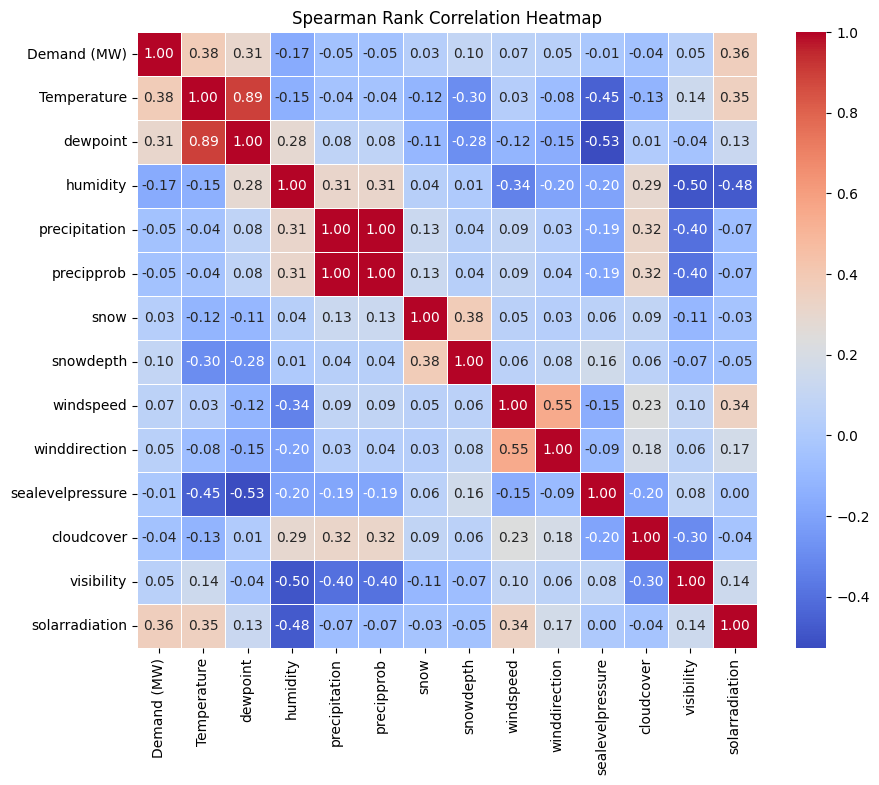

In [61]:
# calculating the spearman rank correlation to asses the monotonic relationship (for non-linear correlation)
# after drop of feelslike and uvindex
all_continuous_data = ["Demand (MW)", "Temperature", "dewpoint", "humidity", "precipitation", "precipprob", "snow", "snowdepth", "windspeed", "winddirection", "sealevelpressure", "cloudcover", "visibility", "solarradiation"]

correlation_matrix = data[all_continuous_data].corr(method="spearman")
plt.figure(figsize = (10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidth = 0.5)
plt.title('Spearman Rank Correlation Heatmap')
plt.show()

In [20]:
# drop the feelslike and uvindex
data = data.drop(["feelslike", "uvindex"], axis = 1)

In [21]:
data.head()

,datetime,Demand (MW),Name,Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,...,visibility,solarradiation,severerisk,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow
0,2020-01-01 00:00:00,445.8,Pokhara,38.0,29.0,69.76,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,1,0,0,0
1,2020-01-01 01:00:00,424.5,Pokhara,38.0,29.9,72.37,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,1,0,0,0
2,2020-01-01 02:00:00,423.5,Pokhara,38.0,30.8,75.06,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,1,0,0,0
3,2020-01-01 03:00:00,418.8,Pokhara,37.1,29.9,74.97,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,0,1,0,0
4,2020-01-01 04:00:00,414.8,Pokhara,35.1,29.0,78.41,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,1,0,0,0,0,0,0


In [22]:
data.columns

Index(['datetime', 'Demand (MW)', 'Name', 'Temperature', 'dewpoint',
       'humidity', 'precipitation', 'precipprob', 'snow', 'snowdepth',
       'windspeed', 'winddirection', 'sealevelpressure', 'cloudcover',
       'visibility', 'solarradiation', 'severerisk', 'Clear',
       'Freezing Drizzle/Freezing Rain', 'Ice', 'Overcast', 'Partially cloudy',
       'Rain', 'Snow'],
      dtype='object')

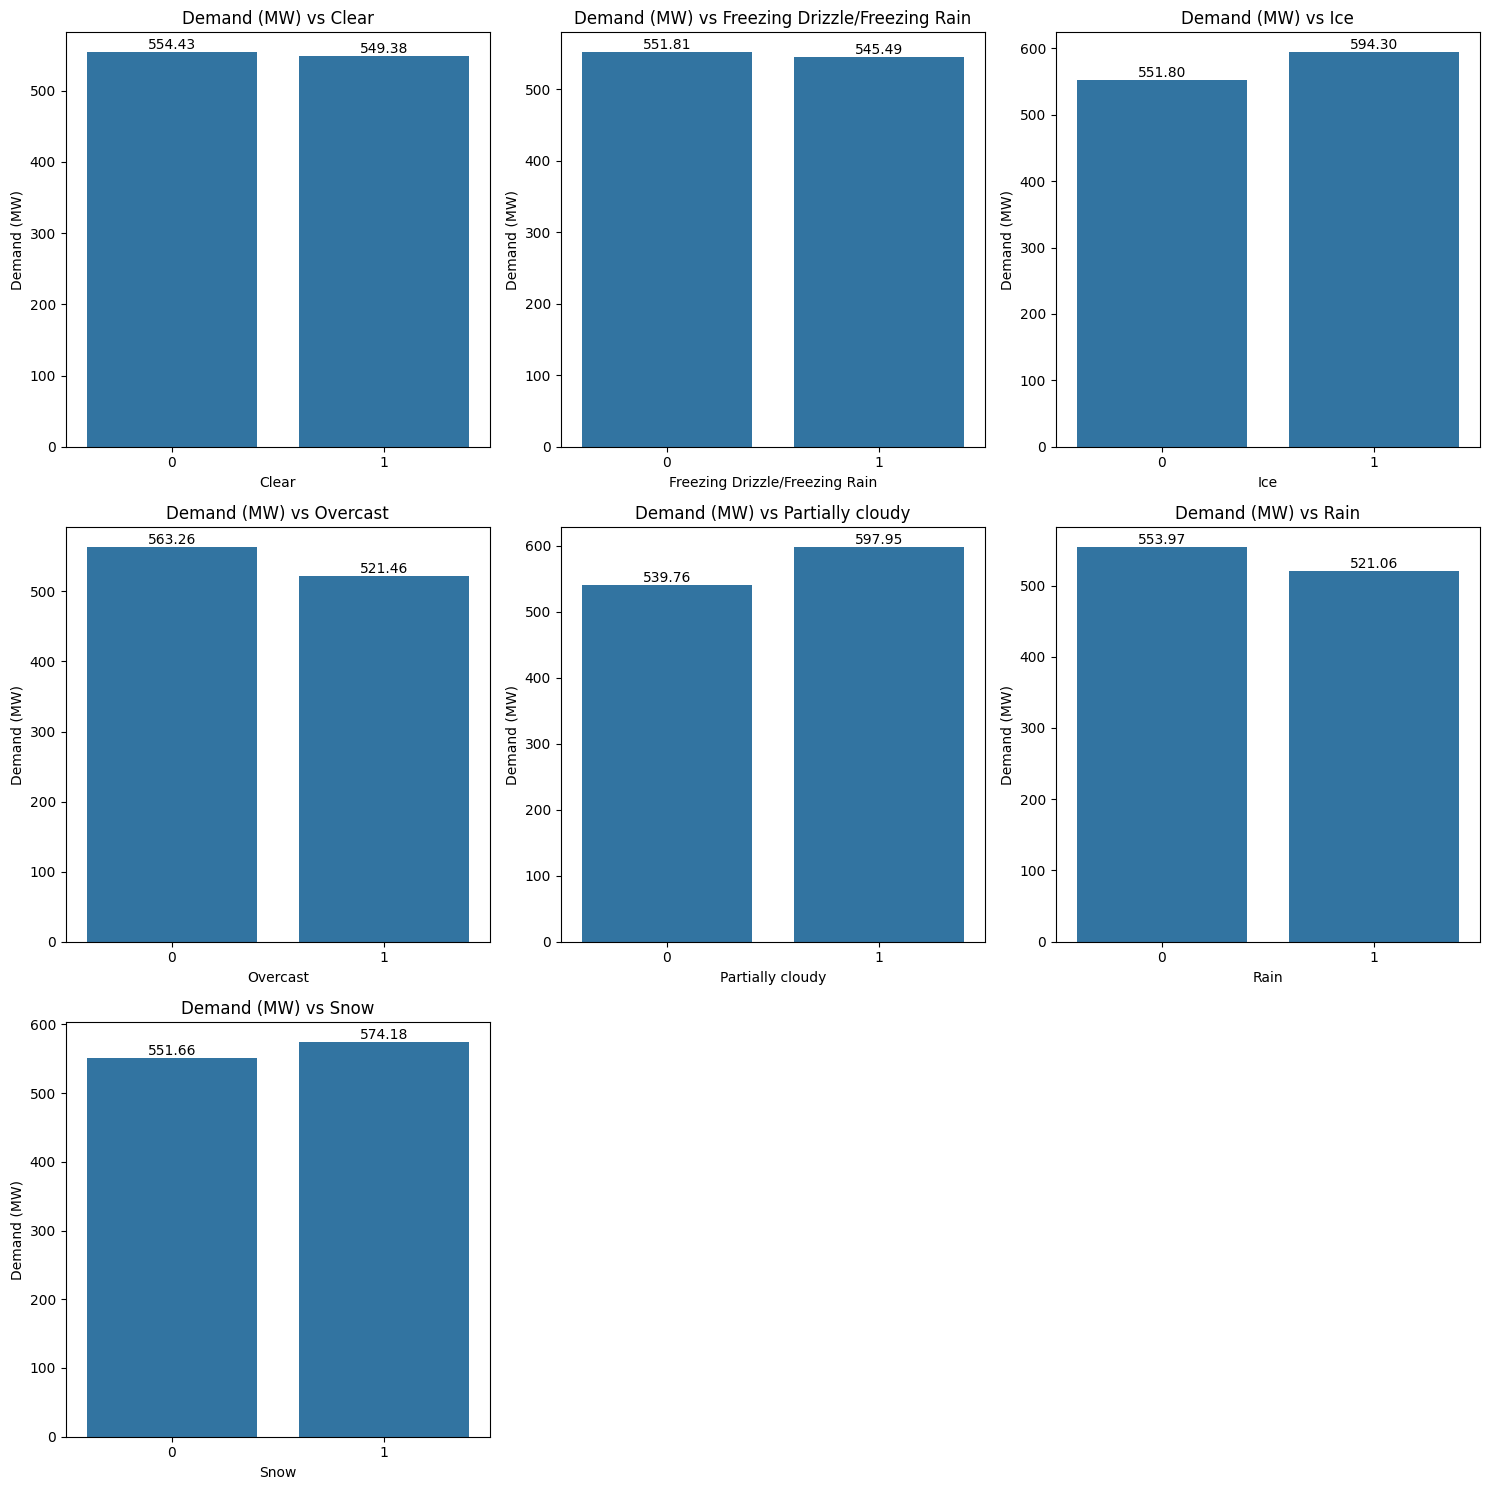

In [37]:
categorical_features = ['Clear', 'Freezing Drizzle/Freezing Rain', 'Ice', 'Overcast', 'Partially cloudy', 'Rain', 'Snow']

n_cols = 3
n_rows = (len(categorical_features) + n_cols) // n_cols

fig, axs = plt.subplots(n_rows, n_cols, figsize = (15, 15))
axs = axs.flatten()

demand_difference = {}

for i, feature in enumerate(categorical_features):
  mean_demand = data.groupby(feature)['Demand (MW)'].mean().reset_index()
  demand_difference[feature] = mean_demand["Demand (MW)"][1] - mean_demand["Demand (MW)"][0]

  sns.barplot(data = mean_demand, x = feature, y = "Demand (MW)", ax = axs[i])
  axs[i].set_title(f"Demand (MW) vs {feature}")

  for p in axs[i].patches:
        height = p.get_height()
        axs[i].annotate(f'{height:.2f}',  # Format the number with 2 decimal places
                        (p.get_x() + p.get_width() / 2., height),  # Position of the text
                        ha='center', va='bottom',  # Horizontal and vertical alignment
                        fontsize=10)  # Font size of the text

for j in range(i + 1, len(axs)):
  axs[j].set_visible(False)

plt.tight_layout()
plt.show()


The overall insights can be obtaine from diffrence bar plot. So, now moving on

In [44]:
demand_difference

{'Clear': -5.052519204361033,
 'Freezing Drizzle/Freezing Rain': -6.322462476888404,
 'Ice': 42.502094677993114,
 'Overcast': -41.80201130319813,
 'Partially cloudy': 58.194185560660685,
 'Rain': -32.90717099744802,
 'Snow': 22.519764992389696}

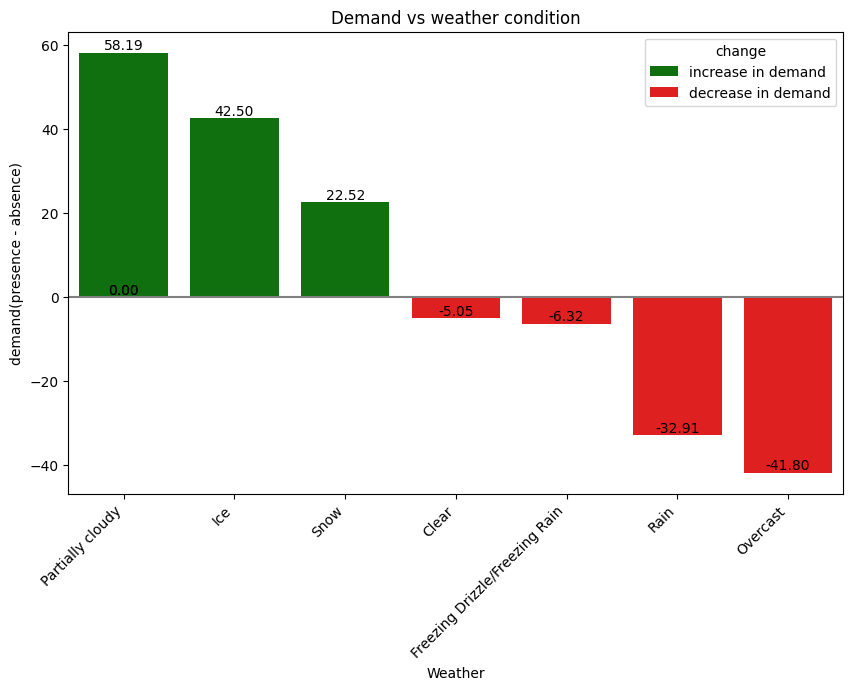

In [63]:
# Convert dictionary to DataFrame
demand_difference_df = pd.DataFrame(list(demand_difference.items()), columns=['Weather', 'demand(presence - absence)'])
demand_difference_df['change'] = demand_difference_df['demand(presence - absence)'].apply(lambda x: 'increase in demand' if x > 0 else 'decrease in demand')

# sort the values
demand_difference_df = demand_difference_df.sort_values(by='demand(presence - absence)', ascending=False)


# Create the barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Weather', y='demand(presence - absence)', data=demand_difference_df, hue = "change", palette = ["green", "red"])


ax.axhline(y=0, color='gray', linestyle='-')

# Add value annotations above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xticks(rotation=45, ha='right')
plt.title('Demand vs weather condition')
plt.show()

From above demand difference plot, we can observe following:
- In partially cloudy days, the mean demand increases by about 58 MW
- While in presence of overcast, the mean demand decrease by about 41 MW.

In [64]:
data.head()

,datetime,Demand (MW),Name,Temperature,dewpoint,humidity,precipitation,precipprob,snow,snowdepth,...,visibility,solarradiation,severerisk,Clear,Freezing Drizzle/Freezing Rain,Ice,Overcast,Partially cloudy,Rain,Snow
0,2020-01-01 00:00:00,445.8,Pokhara,38.0,29.0,69.76,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,1,0,0,0
1,2020-01-01 01:00:00,424.5,Pokhara,38.0,29.9,72.37,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,1,0,0,0
2,2020-01-01 02:00:00,423.5,Pokhara,38.0,30.8,75.06,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,1,0,0,0
3,2020-01-01 03:00:00,418.8,Pokhara,37.1,29.9,74.97,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,0,0,0,0,1,0,0
4,2020-01-01 04:00:00,414.8,Pokhara,35.1,29.0,78.41,0.0,0.0,0.0,0.0,...,9.9,0.0,13.10842,1,0,0,0,0,0,0


In [65]:
data.to_csv(data_dir / "final_data_after_relationship_analysis.csv",index=False)